# CNN Interpretability

Using Captum's Integrated Gradients (IG) and Gradient-weighted Class Activation Mapping (Grad-CAM) to interpret CNN predictions.

## Integrated Gradients

In [1]:
import lightning as L
import torch
import os
from os import path
import sys
from captum.attr import IntegratedGradients

# Grab MLP model and data class from the base training script
# Dynamically construct the path based on the user's home directory
base_path = os.path.expanduser('~/clotsimnet')

# Add the utils directory to sys.path
sys.path.append(os.path.join(base_path, 'ml', 'train_base'))
from train_enet_b0_base import LMDBClotDataModule, ENetB0

/home/josh/anaconda3/envs/clotsimnet/lib/python3.11/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/josh/anaconda3/envs/clotsimnet/lib/python3.11/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


ImportError: cannot import name 'LMDBClotDataModule' from 'train_enet_b0_base' (/home/josh/clotsimnet/ml/train_base/train_enet_b0_base.py)

In [ ]:
learning_rate = 1e-3
weight_decay = 1e-5
kernel_size = 3
stride = 2
padding = 1
first_bias = True
last_bias = True
use_weights = True
batch_size = 16
num_workers = 70
max_epochs = 500
use_transforms = True
        
model = ENetB0(
    use_weights=use_weights,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    kernel_size=kernel_size,
    stride=stride,
    padding=padding
)

In [3]:
# def load_model(model_obj, model_path):
#     if path.isfile(model_path):
#         # Load model
#         print('Loading pre-trained model from: {}'.format(model_path))
#         model_obj.load_state_dict(torch.load(model_path))
#     else:
#         print('Model state_dict not found')
#         pass
    
# SAVED_MODEL_PATH = '/home/josh/clotsimnet/ml/models/enet_b0/enet_b0_test.pth'
# load_model(model_obj=model, model_path=SAVED_MODEL_PATH)


In [3]:
from safetensors import safe_open
def load_safetensors(model_obj, model_path):
    if path.isfile(model_path):
        # Load model
        print('Loading pre-trained model from: {}'.format(model_path))
        tensors = {}
        with safe_open(model_path, framework="pt", device=0) as f:
            for k in f.keys():
                tensors[k] = f.get_tensor(k)
    else:
        print('Model state_dict not found')
        pass

In [ ]:
SAFETENSORS_MODEL_PATH = '/home/josh/ClotSimNet-Models/models/base/enet_b0_base/enet_b0_base.safetensors'
load_safetensors(model_obj=model, model_path=SAFETENSORS_MODEL_PATH)
print(model)

Loading pre-trained model from: /home/josh/ClotSimNet-Models/models/base/enet_b0_base/enet_b0_base.safetensors
ENetB0(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
import piexif
from torchvision.transforms import v2
from PIL import Image


metadata_image = '/home/josh/clotsimnet/data/cnn_data_center_crop/aN_447_rp_01700_seed_500_center_crop.jpeg'

baseline = '/home/josh/clotsimnet/data/test_dataset/cnn_data_512/aN_481_rp_02400_seed_502_cnn_512.jpeg'

# Open image
image = Image.open(metadata_image)

# Load EXIF data
exif_dict = piexif.load(image.info['exif'])

# Extract and decode permeability value
if piexif.ExifIFD.UserComment in exif_dict['Exif']:
    metadata_str = exif_dict['Exif'][piexif.ExifIFD.UserComment].decode("utf-8")
    permeability_value = float(metadata_str)
    print(f'Permeability: {permeability_value}')
    
transform_pipeline = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
    
])

image_tensor = transform_pipeline(image)

# Add batch dimension to image_tensor
input_tensor = image_tensor.unsqueeze(0) # shape: [1, C, H, W]

# Read in another image as the baseline
baseline_image = Image.open(baseline)

baseline_tensor = transform_pipeline(baseline_image).unsqueeze(0)

# Put model into evaluation mode
model.eval()

Permeability: 6.007520420665778e-05


ENetB0(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation): Sigmoid

In [13]:
# Initalize IG from Captum
ig = IntegratedGradients(model)

baseline_tensor_2 = torch.zeros_like(baseline_tensor)

attributions, delta = ig.attribute(input_tensor, baselines=baseline_tensor_2, return_convergence_delta=True,
n_steps=25 # Defulat 50, default could cause kernel to crash
)

In [14]:
# Convert attributions to numpy for visualization
attributions_np = attributions.squeeze().detach().cpu().numpy()

# Normalize attributions
attributions_norm = (attributions_np - attributions_np.min()) / (attributions_np.max() - attributions_np.min())

(-0.5, 511.5, 511.5, -0.5)

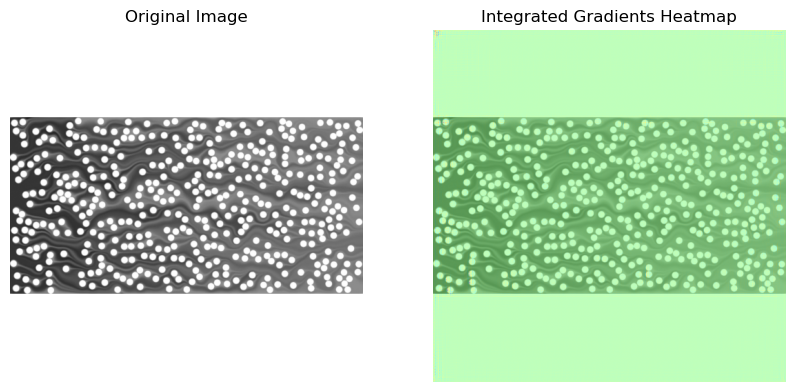

In [15]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.transpose(image_tensor.numpy(), (1, 2, 0)).squeeze(), cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(image_tensor.numpy(), (1, 2, 0)).squeeze(), cmap="gray")
plt.imshow(attributions_norm, cmap='jet', alpha=0.5)
plt.title("Integrated Gradients Heatmap")
plt.axis("off")

To fix image issues: Might want to use multiple random images from the testing dataset, increase/decrease number of steps

# Grad-CAM

In [1]:
import lightning as L
import torch
import os
from os import path
import sys
from captum.attr import IntegratedGradients
from PIL import Image
import piexif
from torchvision.transforms import v2
import numpy as np
import matplotlib.pyplot as plt

# Grab MLP model and data class from the base training script
# Dynamically construct the path based on the user's home directory
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '..')))

from utils import export_cnn, test_report
from model_classes import EfficientNets, ResNets
from data_modules import image_transformations, load_data
from safetensors import safe_open

/home/josh/anaconda3/envs/clotsimnet_v2/lib/python3.11/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/josh/anaconda3/envs/clotsimnet_v2/lib/python3.11/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [2]:
def load_safetensors(model_obj, model_path):
    if path.isfile(model_path):
        # Load model
        print('Loading pre-trained model from: {}'.format(model_path))
        tensors = {}
        with safe_open(model_path, framework="pt", device=0) as f:
            for k in f.keys():
                tensors[k] = f.get_tensor(k)
    else:
        print('Model state_dict not found')
        pass

In [3]:
model = EfficientNets.ENetB7()

SAFETENSORS_MODEL_PATH = '/home/josh/ClotSimNet-Models/base/enet_b7/enet_b7_base.safetensors'
load_safetensors(model_obj=model, model_path=SAFETENSORS_MODEL_PATH)

# Put model into evaluation mode
model.eval()

Loading pre-trained model from: /home/josh/ClotSimNet-Models/base/enet_b7/enet_b7_base.safetensors


ENetB7(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation): Sigmoid()
         

In [4]:
from captum.attr import LayerGradCam
import torch.nn.functional as F
import sys


metadata_image = '/home/josh/clotsimnet/data/cnn_data_test_center_crop/cnn_data_center_crop/aN_447_rp_01700_seed_500_center_crop.jpeg'
# metadata_image = '/home/josh/clotsimnet/data/cnn_data_test_center_crop/cnn_data_center_crop/aN_509_rp_02400_seed_504_center_crop.jpeg'

# baseline = '/home/josh/clotsimnet/data/test_dataset/cnn_data_512/aN_481_rp_02400_seed_502_cnn_512.jpeg'

# Open image
image = Image.open(metadata_image)
    
transform_pipeline = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    v2.CenterCrop((512, 512)),
    v2.ToDtype(torch.float32, scale=True),
    
    # Final normalization (scale to [-1, 1] range)
    v2.Normalize(mean=[0.5], std=[0.5])
])

image_tensor = transform_pipeline(image)

# Add batch dimension to image_tensor
input_tensor = image_tensor.unsqueeze(0) # shape: [1, C, H, W]

prediction = model(input_tensor)

# Target last convolutional layer in CNN
target_layer = model.model.features[-1] # For EfficientNet
# target_layer = model.model.layer4[-1] # For ResNet


# Initialize LayerGradCam
layer_gc = LayerGradCam(model, target_layer)

# Compute Grad-CAM attributions
attributions_gc = layer_gc.attribute(input_tensor)

# Upsample Grad-CAM headmap to match the input size
attributions_gc_upsampled = F.interpolate(attributions_gc,
                                          size=input_tensor.shape[2:],
                                          mode='bilinear')

# Convert to numpy for visualization
attributions_gc_np = attributions_gc_upsampled.squeeze().detach().cpu().numpy()

# Normalize
attributions_gc_norm = (attributions_gc_np - attributions_gc_np.min()) / (attributions_gc_np.max() - attributions_gc_np.min())

image_np = input_tensor[0, 0].cpu().numpy()

# Visualize the original image with the Grad-CAM heatmap
plt.figure(figsize=(6, 6))
plt.imshow(image_np, cmap="gray")
heatmap = plt.imshow(attributions_gc_norm, cmap='jet', alpha=0.5)
# plt.imshow(attributions_gc_norm, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Heatmap: Base EfficientNet-B7", fontweight='bold')
plt.axis("off")
# Add a color bar as a legend for the heatmap
cbar = plt.colorbar(heatmap, fraction=0.046, pad=0.04)
cbar.set_label("Attribution Intensity", rotation=270, labelpad=15, fontweight='bold')
cbar.ax.tick_params(labelsize=10, width=2)
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_weight('bold')

# plt.show()
plt.savefig('small_pack_base_enet_b7.pdf',  format='pdf', bbox_inches='tight')

: 